In [1]:
import sys, os
sys.path.append('../src')
from NeutrinoFogFuncs import *
from NeutrinoFogPlotFuncs import *

In [2]:
import multiprocessing
from NeutrinoFuncs import BinnedNeutrinoRates, BinnedNeutrinoRates2
from WIMPFuncs import BinnedWIMPRate,MeanInverseSpeed_SHM,C_SI, BinnedWIMPRate2
from LabFuncs import FormFactorHelm
from Params import *
#==============================================================================#
ne = 50 # number of energy bins (anything >50 is accurate enough)
nm = 200 # number of mass points
m_vals = np.logspace(log10(0.1),log10(1.0e4),nm) # mass points
Flux_norm = NuFlux # See Params.py
Flux_err = NuUnc # See Params.py
E_th = 1.0e-4 # Threshold
E_max = 200.0 # Max recoil energy

In [3]:
NucList = [Xe131, Ge74, Ar40, He4]

R_sigList = [BinnedWIMPRate(E_th,E_max,ne,m_vals,Nuc,C_SI,FormFactorHelm,MeanInverseSpeed_SHM) for Nuc in NucList]
R_nuList = [BinnedNeutrinoRates(E_th,E_max,ne,Nuc,Flux_norm) for Nuc in NucList]

In [4]:
NucNaI = [Na23,I127]
fNaIList = [22/(22+127), 127/(22+127)]
R_sigNaI = np.sum([fNaIList[i]*BinnedWIMPRate(E_th,E_max,ne,m_vals,\
                    NucNaI[i],C_SI,FormFactorHelm,MeanInverseSpeed_SHM) for i in range(2)], axis=0)
R_nuNaI = np.sum([fNaIList[i]*BinnedNeutrinoRates(E_th,E_max,ne,NucNaI[i],Flux_norm) for i in range(2)], axis=0)

NucCaWO4 = [Ca40,W184,O16]
fCaWO4List = [240/(40+184+4*16), 184/(40+184+4*16), 4*16/(40+184+4*16)]
R_sigCaWO4 = np.sum([fCaWO4List[i]*BinnedWIMPRate(E_th,E_max,ne,m_vals,\
                    NucCaWO4[i],C_SI,FormFactorHelm,MeanInverseSpeed_SHM) for i in range(2)], axis=0)
R_nuCaWO4 = np.sum([fCaWO4List[i]*BinnedNeutrinoRates(E_th,E_max,ne,NucCaWO4[i],Flux_norm) for i in range(2)], axis=0)

In [5]:
R_sigList.extend([R_sigNaI, R_sigCaWO4])
R_nuList.extend([R_nuNaI, R_nuCaWO4])

In [6]:
phi = 9.
fogDatGen = Fog(phiGen2)
#%time res0 = list(map(lambda x: fogDatGen.sigmaExpoListGen(np.logspace(-3.,9.,130), x, R_nuList[0], NuUnc, phi), R_sigList[0]))

In [7]:
def myMul(R_nu, R_sig):
    pool = multiprocessing.Pool(4)
    multiple_results = [pool.apply_async(\
            fogDatGen.sigmaExpoListGen, (np.logspace(-3.,9.,130), x, R_nu, NuUnc, phi))\
                                         for x in R_sig]
    pool.close()
    pool.join()
    res1= [res.get() for res in multiple_results]
    return res1

In [8]:
%time resList = [myMul(R_nuList[i], R_sigList[i]) for i in range(len(R_sigList))]

CPU times: user 3.89 s, sys: 660 ms, total: 4.55 s
Wall time: 30.6 s


In [9]:
def vFogPlot3(resList, m_vals, color, targetList):
    #
    n = 5
    colors = np.zeros([n,4])
    colors[0] = mpl.colors.to_rgba(color)
    colors[:] = mpl.colors.to_rgba(color)
    colors[:,3] = [0., 0.2, 0.4, 0.6, 0.8]
    cmap = mpl.colors.ListedColormap(colors, name='test')
    pek = line_background(10,'k')
    xlab=r"DM mass [GeV]"
    ylab=r"SI DM-nucleon cross section [cm$^2$]"
    lfs = 35
    
    fig, ax = plt.subplots(2,3, figsize=(40,20))
    for i in range(6):
        axx, axy = int(i/3), i%3
        ax[axx,axy]=MakeLimitPlot_SI2023X(ax[axx,axy],xmin=1.0e-1,xmax=1.0e4,ymin=1e-50,ymax=1e-41,\
                     facecolor='darkgray',edgecolor='darkgray',edgecolor_collected='darkgray',\
                     alph=0.5,lfs=35,tfs=25)
        m,sig,DY = plotDatGen2(m_vals, resList[i])
        cnt = ax[axx,axy].contourf(m,sig,DY,np.array([1.5, 2., 2.5, 3., 3.5]),\
                       cmap=cmap, vmin=1. , vmax=3.5 )
        for c in cnt.collections:
            c.set_edgecolor("face")
        NUFLOOR = np.array([m_vals, np.transpose(np.array(list(map(findPoint, resList[i]))))[1]])
        [edgeX, edgeY] = NUFLOOR
        ax[axx,axy].plot(edgeX,edgeY,'-',color=color,lw=3,path_effects=pek,zorder=100)
        #ax[axx,axy].text(0.15*(1-0.01),0.16*(1+0.01),r'\bf {0} neutrino fog'.format(targetList[i]),color='k',fontsize=30,alpha=0.2)
        ax[axx,axy].text(0.12,3e-50,r'\bf {0} neutrino fog'.format(targetList[i]),color='black',fontsize=30)
        if [axx,axy]==[0,0] or [axx,axy]==[1,0]:
            ax[axx,axy].set_ylabel(ylab,fontsize=lfs)
        if axx==1:  
            ax[axx,axy].set_xlabel(xlab,fontsize=lfs)

    cmap2 = mpl.colors.ListedColormap(colors[1:-1], name='test')
    cmap2.set_under(color=color, alpha=0.)
    cmap2.set_over(color=color, alpha=1.)
    im = plt.pcolormesh(-m,sig,DY,vmax=3.,vmin=1.5,cmap=cmap2,rasterized=True,shading='auto')
    #fig.subplots_adjust(top=0.8)
    cbar_ax = fig.add_axes([0.912, 0.14, 0.013, 0.7])
    fig.colorbar(im, cax=cbar_ax,orientation='vertical',extend='both',extendfrac=0.03, ticks=[1.5,2,2.5,3.])
    cbar_ax.yaxis.set_ticks_position('right')
    return fig

def MakeLimitPlot_SI2023X(ax, xmin=0.1,xmax=1.0e4,ymax=1.0e-36,ymin=1.0e-51,\
                     facecolor=[0.0, 0.62, 0.38],edgecolor='darkgreen',edgecolor_collected='darkgray',\
                     alph=0.5,lfs=35,tfs=25):
    pek = line_background(5,'k')

    AllLimits = loadtxt("../data/WIMPLimits/SI/AllLimits-2023.txt")
    ax.fill_between(AllLimits[:,0], AllLimits[:,1],edgecolor=None,y2=ymax,facecolor=facecolor,alpha=alph,zorder=0)
    ax.plot(AllLimits[:,0], AllLimits[:,1],color=edgecolor_collected,linewidth=3,alpha=alph,zorder=0.01)
    for lim in ['CDMSLite','DarkSide','PandaX','XENON1T','LUX','DEAP-3600','EDELWEISS','PICO60','XENONnT','PandaX4T']:
        dat = loadtxt("../data/WIMPLimits/SI/"+lim+".txt")
        ax.plot(dat[:,0], dat[:,1],color=edgecolor,linewidth=3,alpha=alph,zorder=0)

    # Labels
    
    ax.tick_params(which='major',direction='in',width=2,length=13,right=True,top=True,pad=7)
    ax.tick_params(which='minor',direction='in',width=1,length=10,right=True,top=True)

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_yticks(10.0**arange(-51,-30,1))
    ax.tick_params(which='major',pad=10)
    ax.set_xlim(left=xmin, right=xmax)
    ax.set_ylim(bottom=ymin, top=ymax)
    return ax

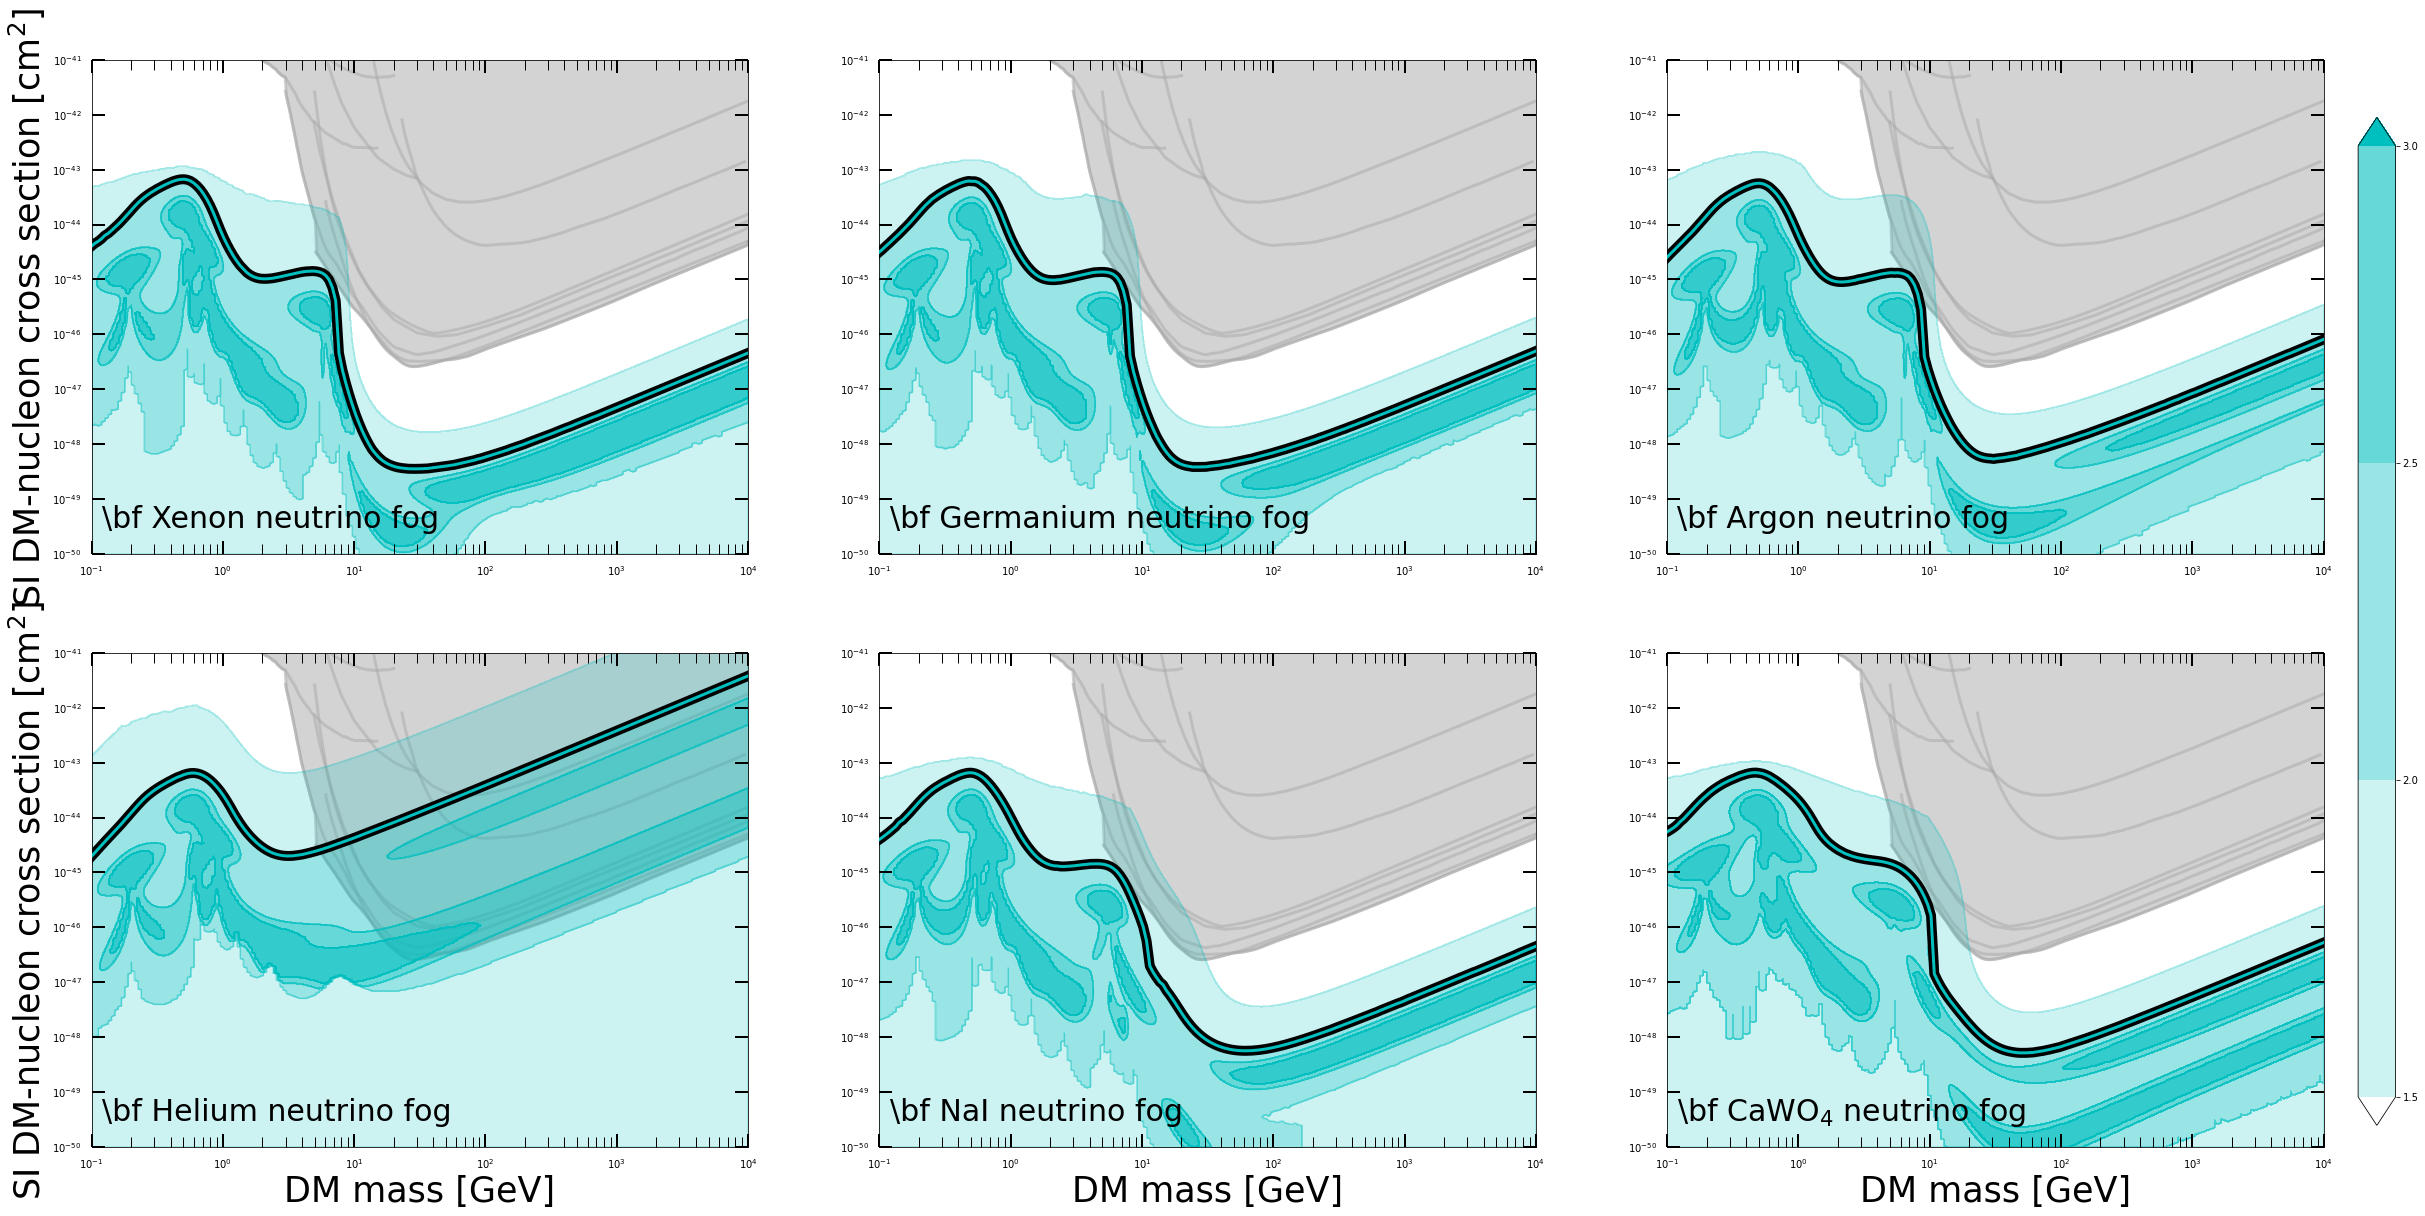

In [10]:
targetList = ['Xenon','Germanium','Argon','Helium','NaI','CaWO$_4$']
method2P0 = vFogPlot3(resList, m_vals, 'c', targetList)

In [11]:
myPathFig = os.path.join(os.path.abspath(os.path.pardir),'plots')
method2P0.savefig(os.path.join(myPathFig,'DifferentTargets.pdf'),bbox_inches='tight')
method2P0.savefig(os.path.join(myPathFig,'png','DifferentTargets.png'),bbox_inches='tight')

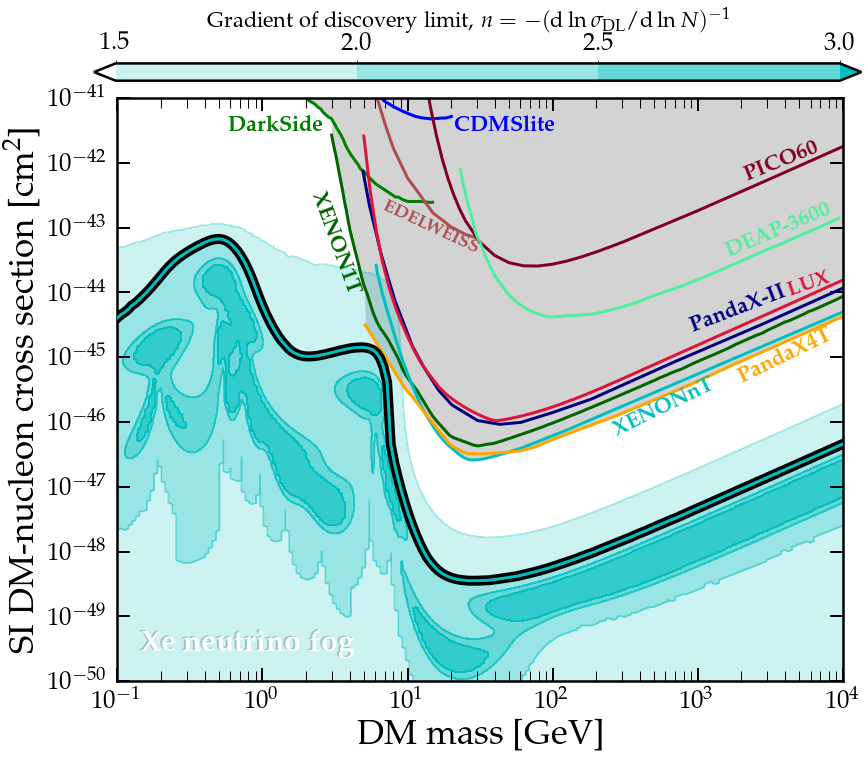

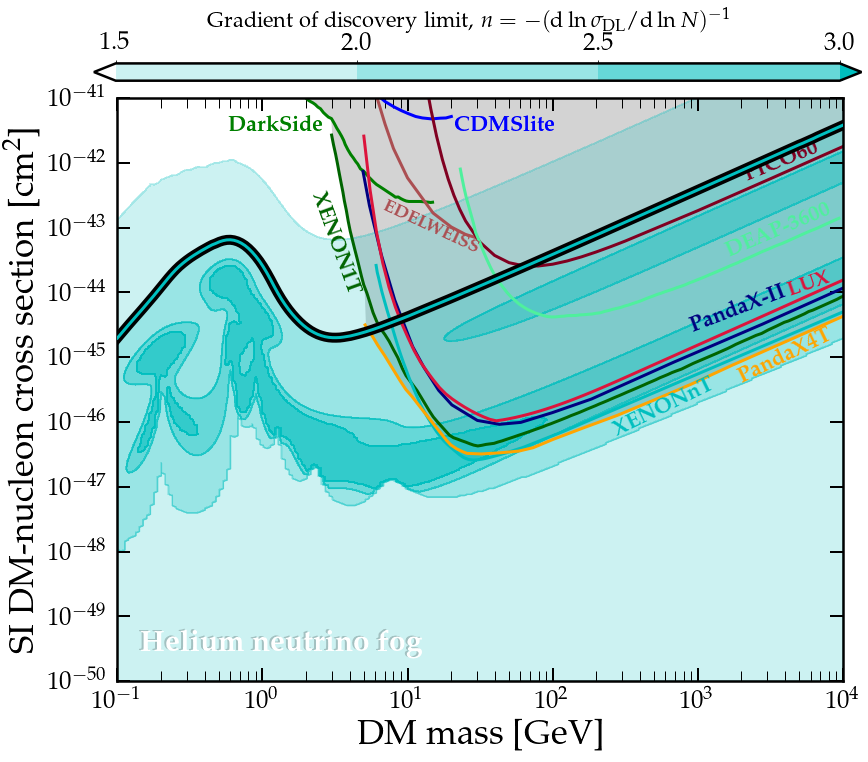

In [12]:
method2P0 = vFogPlot2(resList[0], m_vals, 'c', 'Xe')
method2P0 = vFogPlot2(resList[3], m_vals, 'c', 'Helium')

In [13]:
alph = 0.2
nufloor_col = '#e68525'
pek = line_background(6,'k')
nucs = ['Xe','Ge','Ar','He','NaI','CaWO4']
zos = [-100,-200,-300,-400,-500,-600]
cols = [nufloor_col,'crimson','royalblue','teal','y','m']

cdat = [Floor_2D(loadtxt('../data/WIMPLimits/mylimits/DLNuFloor'+nuc+'_detailed_SI.txt'),filt=True,filt_width=2) for nuc in nucs]
nufloorList = [np.transpose(np.array(list(map(findPoint, res))))[1] for res in resList]

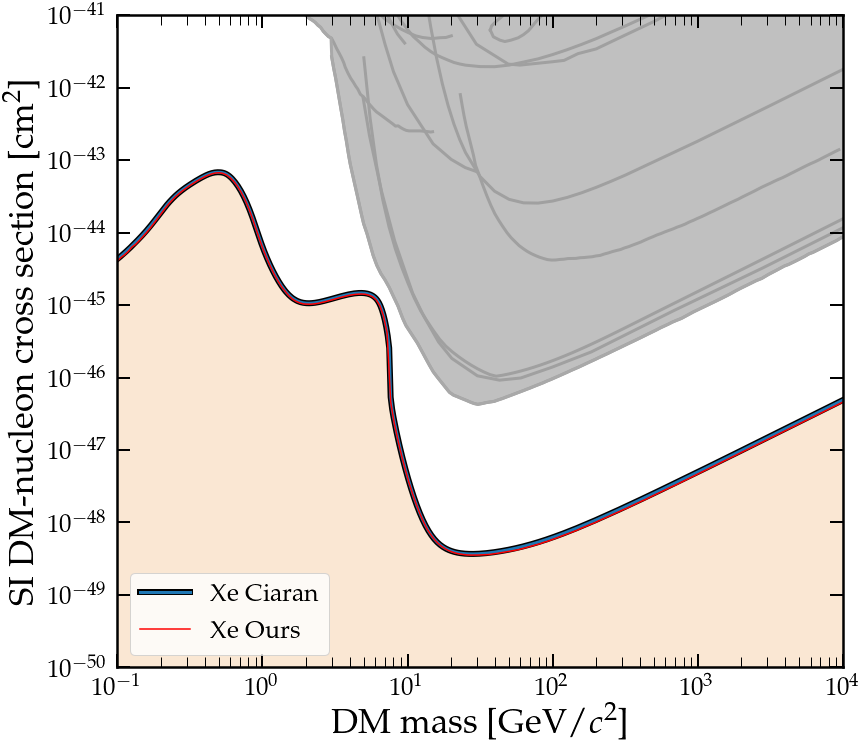

In [14]:
fig,ax = MakeLimitPlot_SI(Collected=True,alph=1,edgecolor=col_alpha('gray',0.75),facecolor=col_alpha('gray',0.5),ymin=1e-50,ymax=1e-41)
i=0
plt.fill_between(cdat[i][0],cdat[i][2],y2=1e-99,color=col_alpha(cols[i],alph),zorder=zos[i])
plt.plot(cdat[i][0],cdat[i][2],lw=3,path_effects=pek,zorder=zos[i],label='Xe Ciaran')
plt.plot(m_vals,nufloorList[i],color='r',zorder=0,label='Xe Ours')
plt.legend()

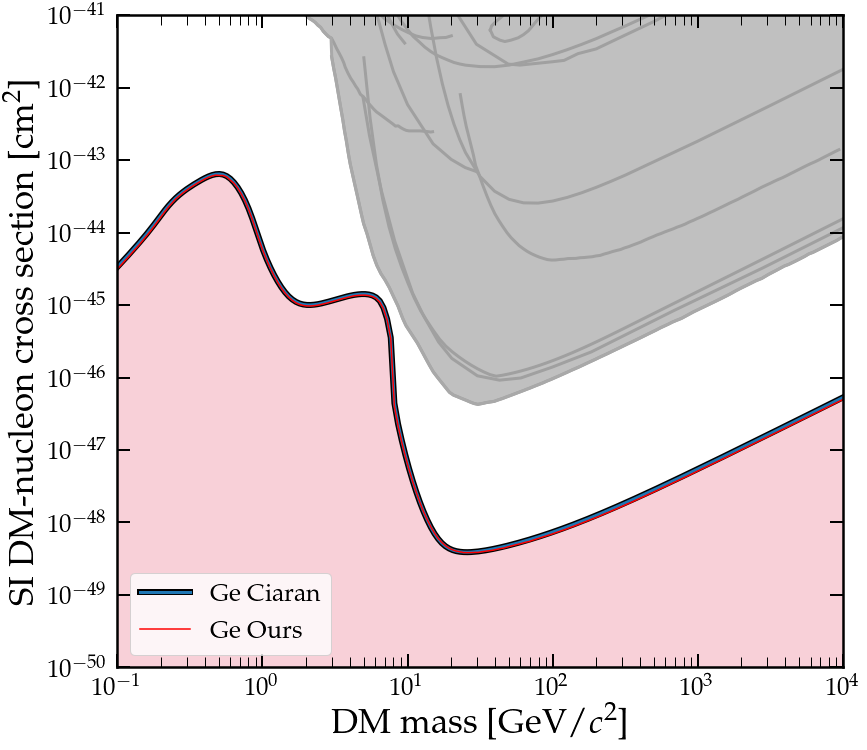

In [15]:
fig,ax = MakeLimitPlot_SI(Collected=True,alph=1,edgecolor=col_alpha('gray',0.75),facecolor=col_alpha('gray',0.5),ymin=1e-50,ymax=1e-41)
i=1
plt.fill_between(cdat[i][0],cdat[i][2],y2=1e-99,color=col_alpha(cols[i],alph),zorder=zos[i])
plt.plot(cdat[i][0],cdat[i][2],lw=3,path_effects=pek,zorder=zos[i],label='Ge Ciaran')
plt.plot(m_vals,nufloorList[i],color='r',zorder=0,label='Ge Ours')
plt.legend()

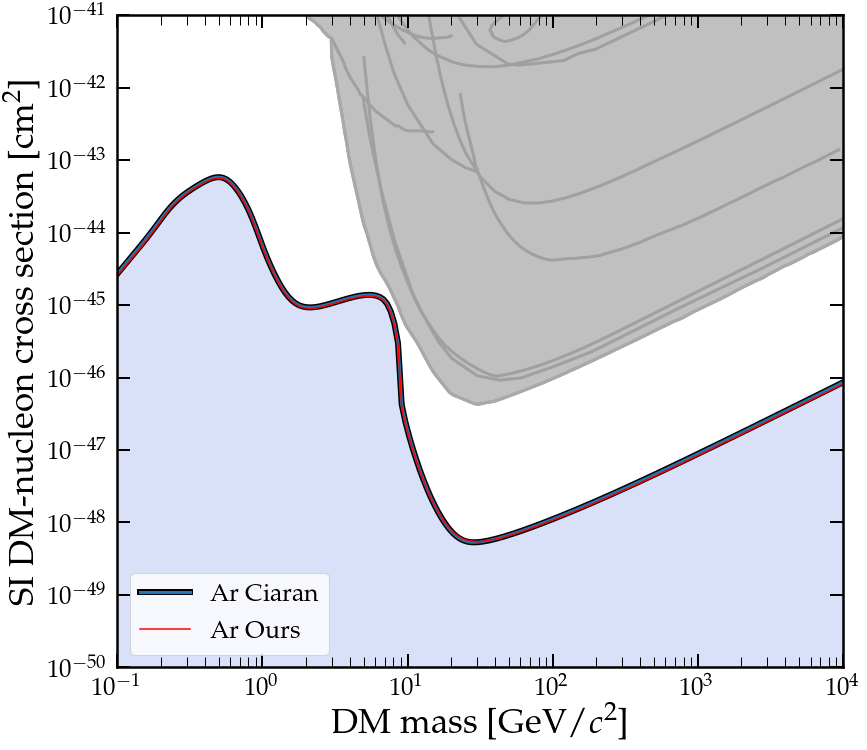

In [16]:
fig,ax = MakeLimitPlot_SI(Collected=True,alph=1,edgecolor=col_alpha('gray',0.75),facecolor=col_alpha('gray',0.5),ymin=1e-50,ymax=1e-41)
i=2
plt.fill_between(cdat[i][0],cdat[i][2],y2=1e-99,color=col_alpha(cols[i],alph),zorder=zos[i])
plt.plot(cdat[i][0],cdat[i][2],lw=3,path_effects=pek,zorder=zos[i],label='Ar Ciaran')
plt.plot(m_vals,nufloorList[i],color='r',zorder=0,label='Ar Ours')
plt.legend()

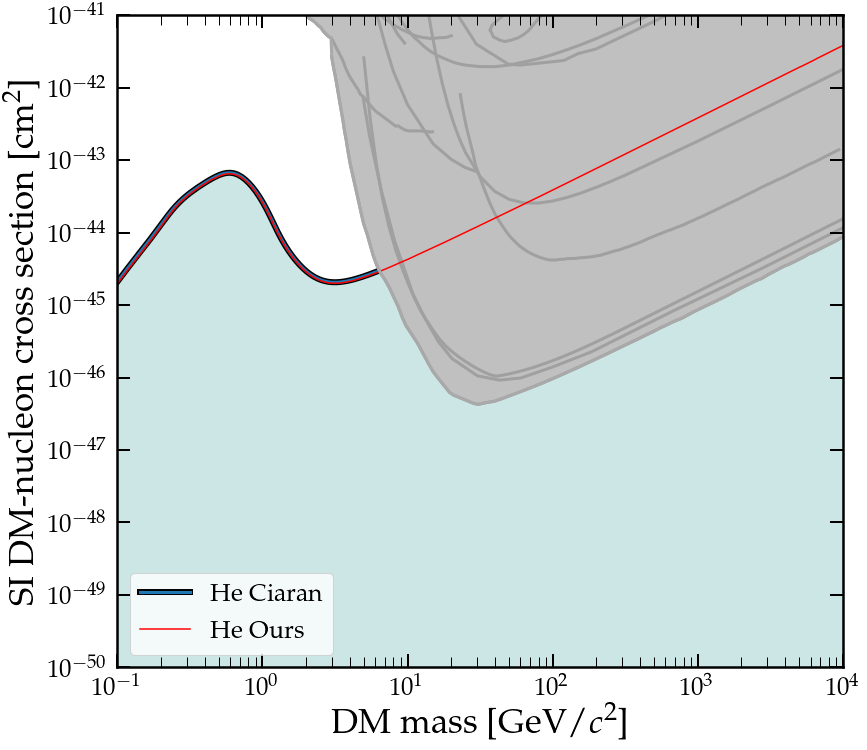

In [17]:
fig,ax = MakeLimitPlot_SI(Collected=True,alph=1,edgecolor=col_alpha('gray',0.75),facecolor=col_alpha('gray',0.5),ymin=1e-50,ymax=1e-41)
i=3
plt.fill_between(cdat[i][0],cdat[i][2],y2=1e-99,color=col_alpha(cols[i],alph),zorder=zos[i])
plt.plot(cdat[i][0],cdat[i][2],lw=3,path_effects=pek,zorder=zos[i],label='He Ciaran')
plt.plot(m_vals,nufloorList[i],color='r',zorder=0,label='He Ours')
plt.legend()

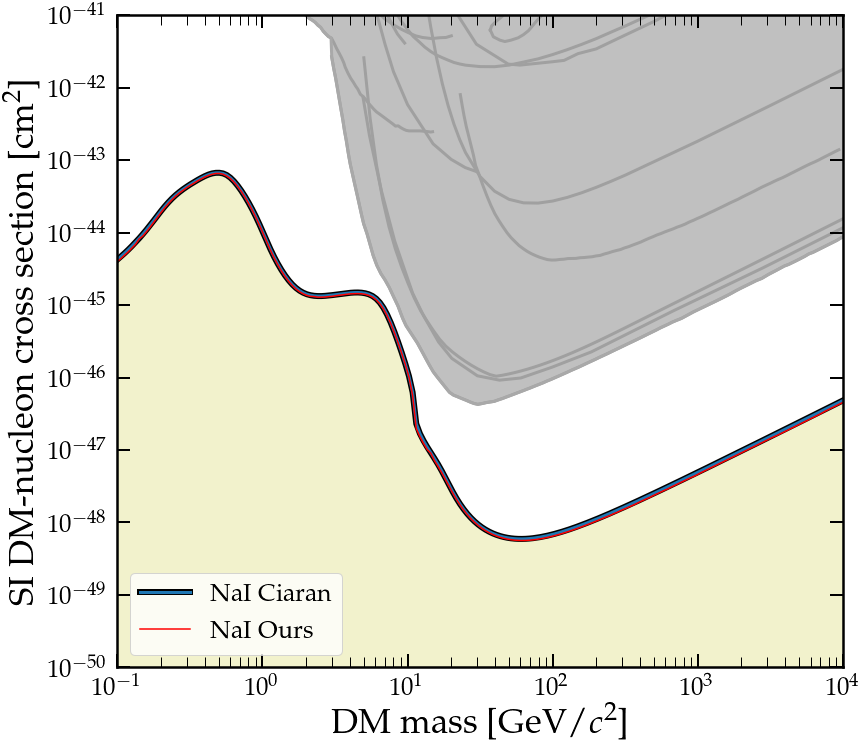

In [18]:
fig,ax = MakeLimitPlot_SI(Collected=True,alph=1,edgecolor=col_alpha('gray',0.75),facecolor=col_alpha('gray',0.5),ymin=1e-50,ymax=1e-41)
i=4
plt.fill_between(cdat[i][0],cdat[i][2],y2=1e-99,color=col_alpha(cols[i],alph),zorder=zos[i])
plt.plot(cdat[i][0],cdat[i][2],lw=3,path_effects=pek,zorder=zos[i],label='NaI Ciaran')
plt.plot(m_vals,nufloorList[i],color='r',zorder=0,label='NaI Ours')
plt.legend()

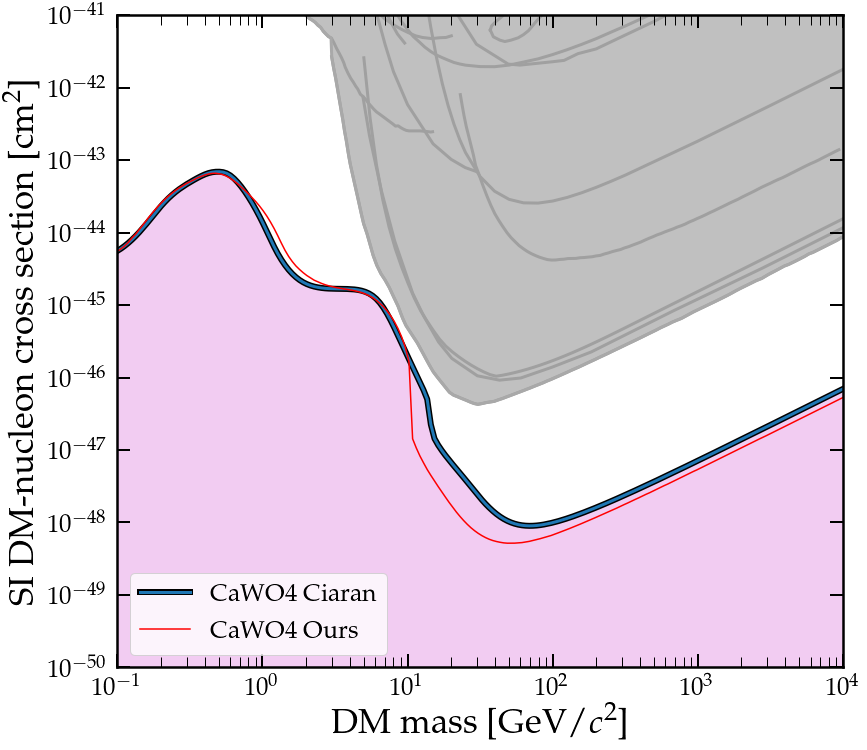

In [19]:
fig,ax = MakeLimitPlot_SI(Collected=True,alph=1,edgecolor=col_alpha('gray',0.75),facecolor=col_alpha('gray',0.5),ymin=1e-50,ymax=1e-41)
i=5
plt.fill_between(cdat[i][0],cdat[i][2],y2=1e-99,color=col_alpha(cols[i],alph),zorder=zos[i])
plt.plot(cdat[i][0],cdat[i][2],lw=3,path_effects=pek,zorder=zos[i],label='CaWO4 Ciaran')
plt.plot(m_vals,nufloorList[i],color='r',zorder=0,label='CaWO4 Ours')
plt.legend()